# Compare spatial stats between groups

## Setup 
Imports

In [63]:
import os
import re
import gc
import sys
import glob
import yaml
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import time, sleep
from collections import defaultdict
import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc

Get workdir

In [2]:
cluster = ""
workdir = "/workdir/bmg224/harvard_dental/manuscript/code"
os.chdir(cluster + workdir)


In [70]:
os.getcwd()

'/local/workdir/bmg224/harvard_dental/manuscript/code'

In [6]:
%load_ext autoreload
%autoreload 2
functions_path = '/workdir/bmg224/manuscripts/mgefish/code/functions'

sys.path.append(cluster + functions_path)

# import fn_general_use as fgu
# import image_plots as ip
# import segmentation_func as sf
# import fn_hiprfish_classifier as fhc
# import fn_spectral_images as fsi
# import fn_analysis_plots as apl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get czi filenames

In [7]:
input_table_fn = "input_table_all.csv"
input_table = pd.read_csv(input_table_fn)
filenames = input_table["filenames"]

In [8]:
dict_date_sn_fns = defaultdict(lambda: defaultdict(list))
for fn in filenames:
    bn = os.path.split(fn)[1]
    date, bn = re.split("(?<=^\d{4}_\d{2}_\d{2})_", bn)
    sn, ext = re.split("(?<=fov_\d{2})", bn)
    dict_date_sn_fns[date][sn].append(fn)

## Define groups

In [22]:
dict_group_sn = {
    "healthy_tooth": [
        "2023_02_18_hsdm_group_batch1_patient_1_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_1_fov_02",
        "2023_02_18_hsdm_group_batch2_patient_10_fov_01",
        "2023_02_18_hsdm_group_batch2_patient_9_fov_01",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_10_tooth_8_aspect_MB_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_1_tooth_31_aspect_ML_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_9_tooth_15_aspect_MB_depth_supra_fov_03",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_01",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_02",
        "2022_12_16_harvardwelch_patient_9_tooth_3_aspect_D_depth_supra_fov_03",
    ],
    "periodontitis_tooth": [
        "2023_02_18_hsdm_group_batch2_patient_11_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_2_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_3_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_4_fov_01",
        "2023_02_18_hsdm_group_batch1_patient_7_fov_01",
    ],
    "healthy_implant": [
        "2023_02_18_hsdm_group_I_patient_11_fov_01",
        "2023_02_18_hsdm_group_I_patient_11_fov_02",
        "2023_02_18_hsdm_group_I_patient_13_fov_01",
        "2023_02_18_hsdm_group_I_patient_6_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_03",
        "2023_02_08_hsdm_group_1_sample_06_fov_01",
        "2023_02_08_hsdm_group_1_sample_11_fov_01",
        "2023_02_08_hsdm_group_1_sample_12_fov_01",
        "2023_10_16_hsdm_slide_IB_fov_02",
        "2023_10_16_hsdm_slide_IL_fov_01",
        "2023_10_16_hsdm_slide_IL_fov_02",
        "2023_10_16_hsdm_slide_IL_fov_03",
    ],
    "severe_implant": [
        "2023_02_18_hsdm_group_IV_patient_1_fov_01",
        "2023_02_18_hsdm_group_IV_patient_1_fov_02",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_01",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_02",
        "2022_12_16_harvardwelch_patient_14_tooth_14_aspect_MB_depth_sub_fov_03",
        "2022_12_16_harvardwelch_patient_18_tooth_2_aspect_MB_depth__fov_01",
        "2022_12_16_harvardwelch_patient_19_tooth_15_aspect_MF_depth_sub_fov_01",
        "2022_12_16_harvardwelch_patient_19_tooth_30_aspect_MB_depth_sub_fov_01",
        "2023_02_08_hsdm_group_4_sample_01_fov_01",
        "2023_02_08_hsdm_group_4_sample_01_fov_02",
    ],
    "mucositis_implant": [
        "2023_02_18_hsdm_group_II_patient_6_fov_01",
        "2023_02_18_hsdm_group_II_patient_7_fov_01",
        "2023_02_18_hsdm_group_II_patient_7_fov_02",
        "2023_02_08_hsdm_group_2_sample_06_fov_01",
        "2023_02_08_hsdm_group_2_sample_06_fov_02",
        "2023_10_18_hsdm_slide_IIL_fov_01",
    ],
    "moderate_implant": [
        "2023_10_18_hsdm_slide_IIIB_fov_01",
        "2023_10_18_hsdm_slide_IIIL_fov_01",
    ],
}

# Load feature matrix

In [9]:
sample_compare_dir =  '../outputs/segmentation_2024_03_07/compare_samples'
feature_matrix_fn = sample_compare_dir + '/samples_feature_matrix.csv'

In [42]:
feature_matrix = pd.read_csv(feature_matrix_fn, index_col=0)
feature_matrix = feature_matrix.fillna(0)
X = feature_matrix.values
feature_matrix.shape

(52, 360)

In [43]:
adata = ad.AnnData(X)
adata.obs_names = feature_matrix.index
adata.var_names = feature_matrix.columns


In [44]:
dict_sn_group = {}
for k, vs in dict_group_sn.items():
    for v in vs:
        dict_sn_group[v] = k

sample_types = [dict_sn_group[sn] for sn in feature_matrix.index.values]
adata.obs["sample_type"] = sample_types

Broadest grouping by health or disease

In [45]:
dict_group_supergroup = {
    'healthy_tooth': 'healthy',
    'periodontitis_tooth': 'disease',
    'healthy_implant': 'healthy',
    'severe_implant': 'disease',
    'mucositis_implant': 'disease',
    'moderate_implant': 'disease',
}

sample_types_super = [dict_group_supergroup[gr] for gr in sample_types]
adata.obs["sample_type_super"] = sample_types_super

Group implants by health or disease

In [46]:
dict_group_implantgroup = {
    "healthy_tooth": "healthy_tooth",
    "periodontitis_tooth": "periodontitis_tooth",
    "healthy_implant": "healthy_implant",
    "severe_implant": "disease_implant",
    "mucositis_implant": "disease_implant",
    "moderate_implant": "disease_implant",
}

sample_types_implant = [dict_group_implantgroup[gr] for gr in sample_types]
adata.obs["sample_type_implant"] = sample_types_implant

## Raw Gene ranking

Each vs all

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[g

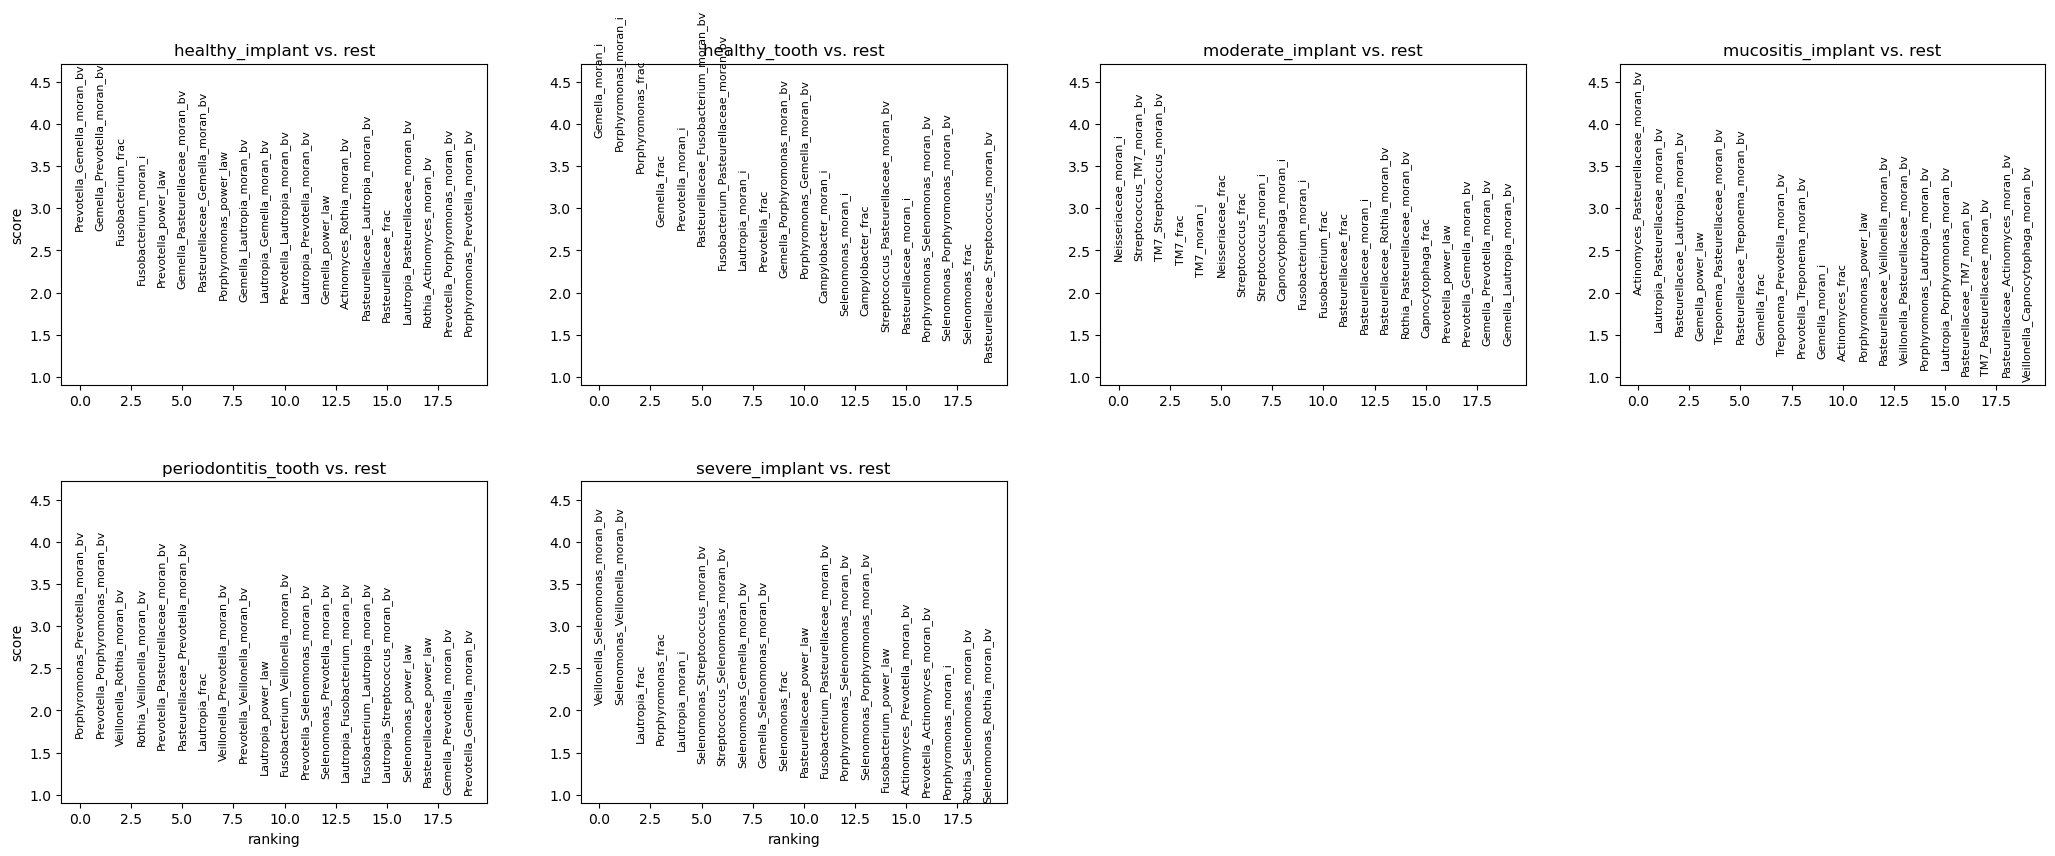

In [25]:
sc.tl.rank_genes_groups(adata, "sample_type", method="wilcoxon")
sc.pl.rank_genes_groups(adata)

Overall healthy vs disease

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


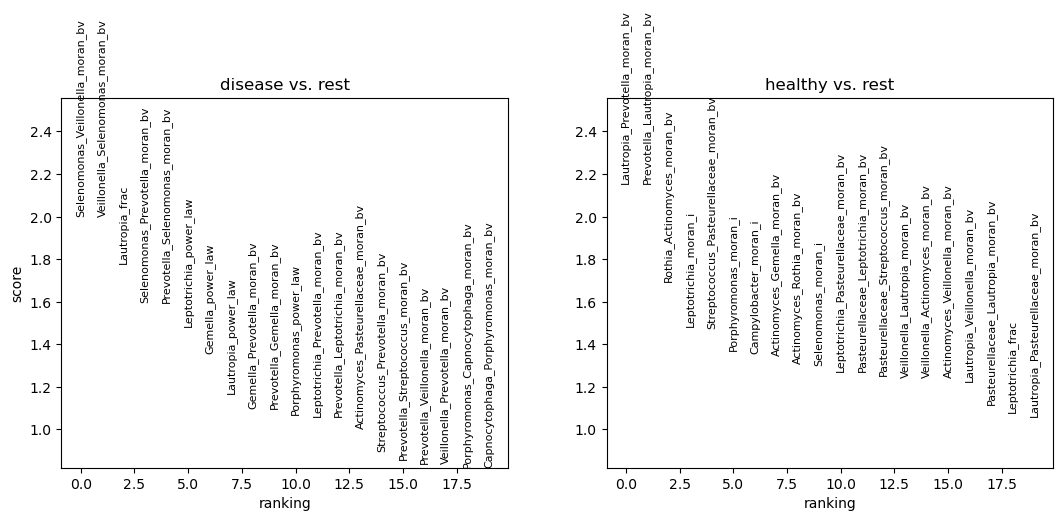

In [27]:
sc.tl.rank_genes_groups(adata, "sample_type_super", method="wilcoxon")
sc.pl.rank_genes_groups(adata)

Implant grouping vs rest

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


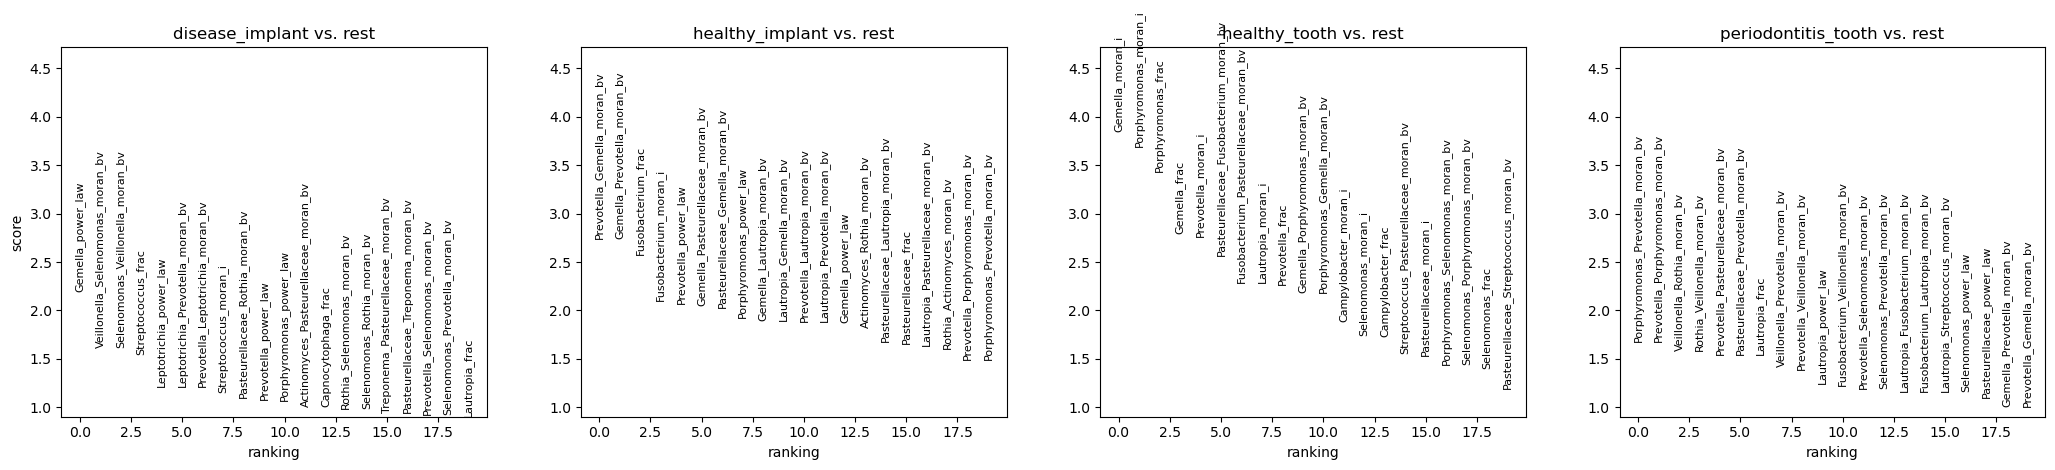

In [37]:
sc.tl.rank_genes_groups(
    adata, 
    "sample_type_implant", 
    method="wilcoxon"
)
sc.pl.rank_genes_groups(adata)

Implant comparison

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


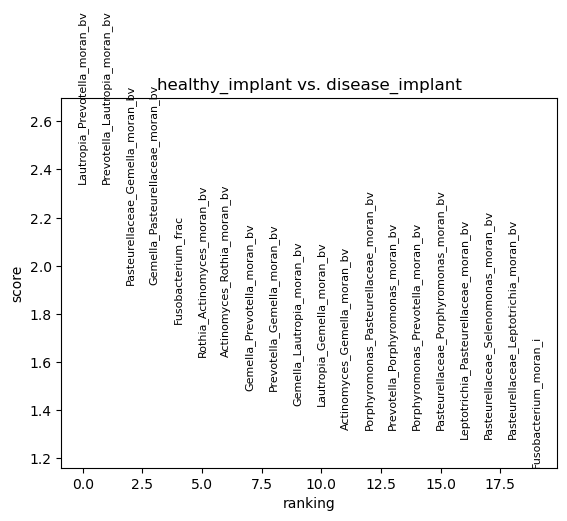

In [32]:
sc.tl.rank_genes_groups(
    adata, 
    "sample_type_implant", 
    groups=['healthy_implant', 'disease_implant'],
    reference='disease_implant',
    method="wilcoxon"
)
sc.pl.rank_genes_groups(adata)

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


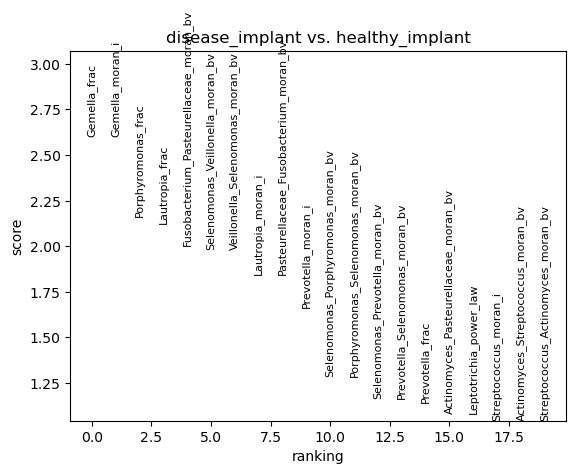

In [33]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type_implant",
    groups=["healthy_implant", "disease_implant"],
    reference="healthy_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

Tooth comparison

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


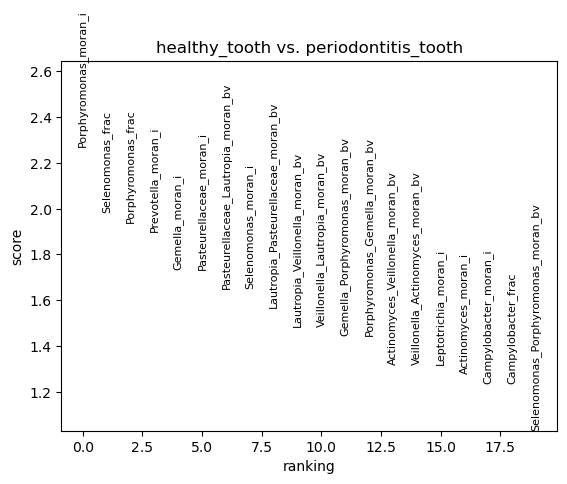

In [35]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["healthy_tooth", "periodontitis_tooth"],
    reference='periodontitis_tooth',
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


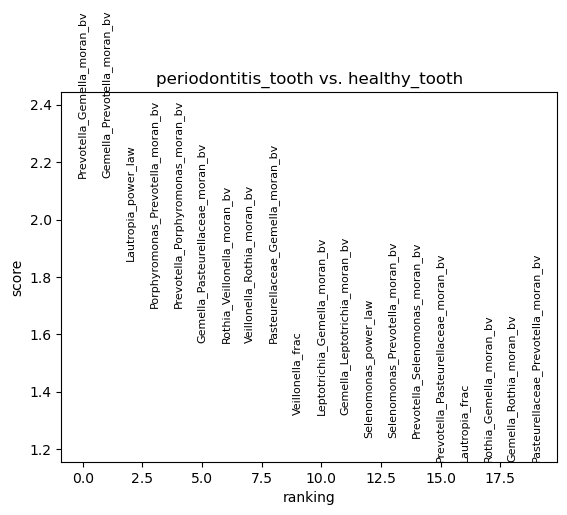

In [36]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["healthy_tooth", "periodontitis_tooth"],
    reference="healthy_tooth",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

Within disease implant

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


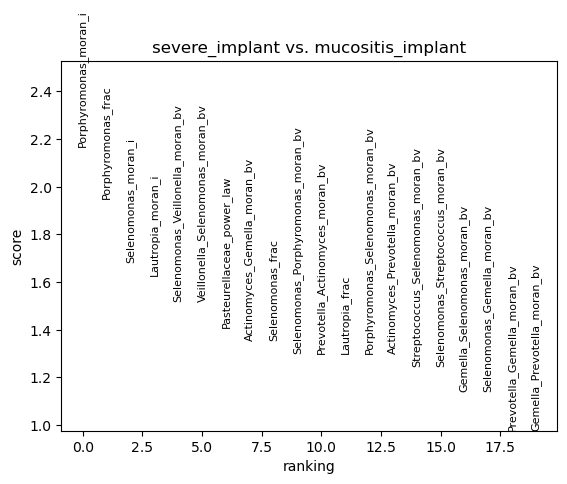

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


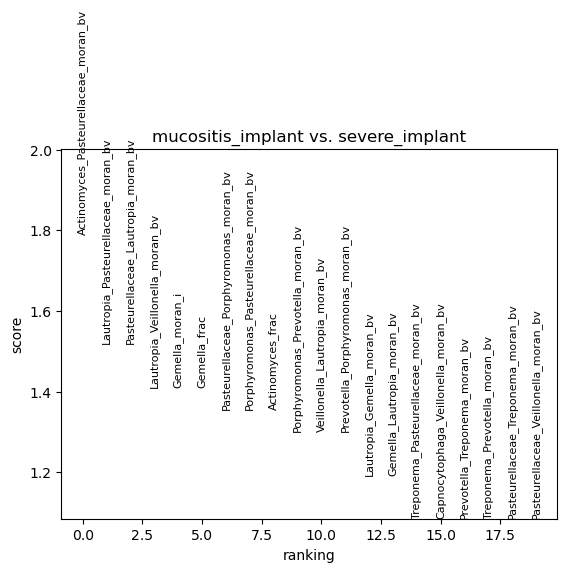

In [48]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["severe_implant"],
    reference="mucositis_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["mucositis_implant"],
    reference="severe_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


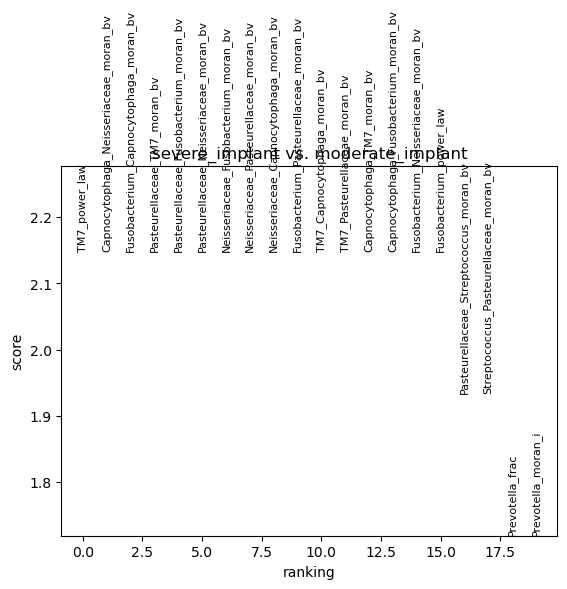

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


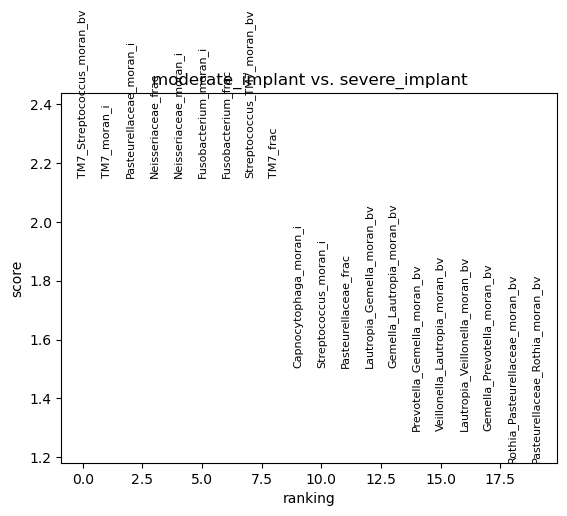

In [49]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["severe_implant"],
    reference="moderate_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["moderate_implant"],
    reference="severe_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


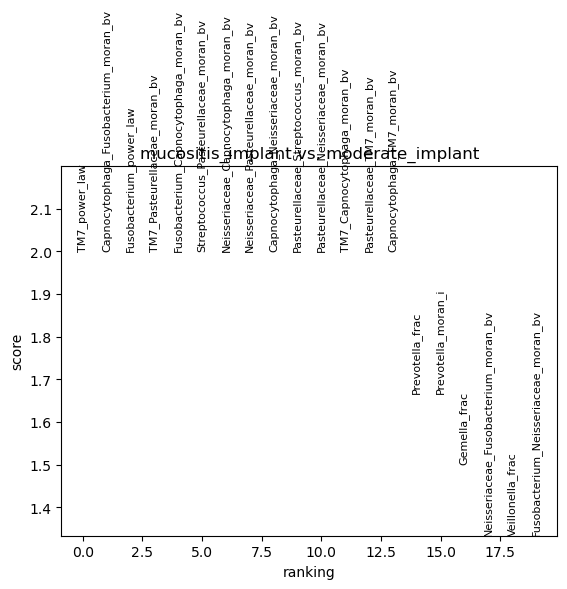

/home/bmg224/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


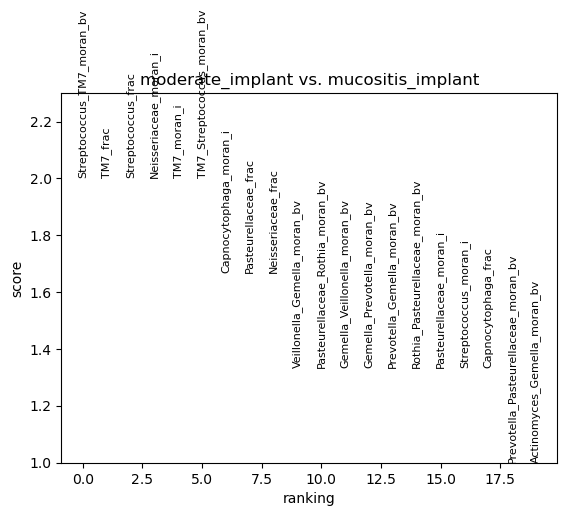

In [50]:
sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["mucositis_implant"],
    reference="moderate_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

sc.tl.rank_genes_groups(
    adata,
    "sample_type",
    groups=["moderate_implant"],
    reference="mucositis_implant",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata)

### Plot diff values

healthy vs disease

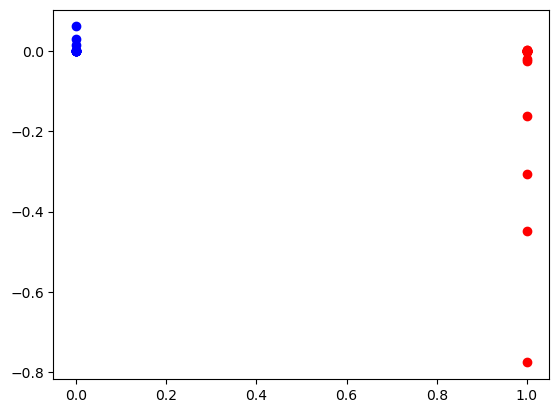

In [69]:
stat = "Lautropia_Prevotella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0] * len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

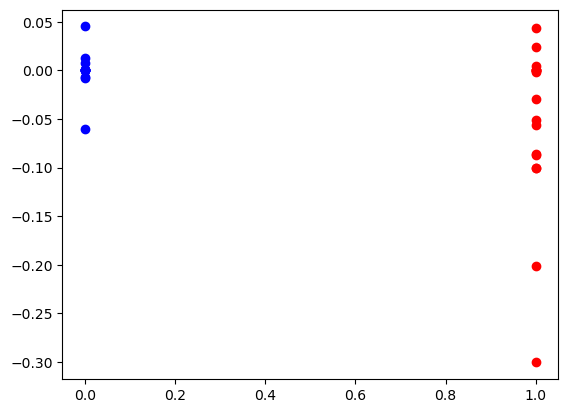

In [92]:
stat = "Pasteurellaceae_Gemella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

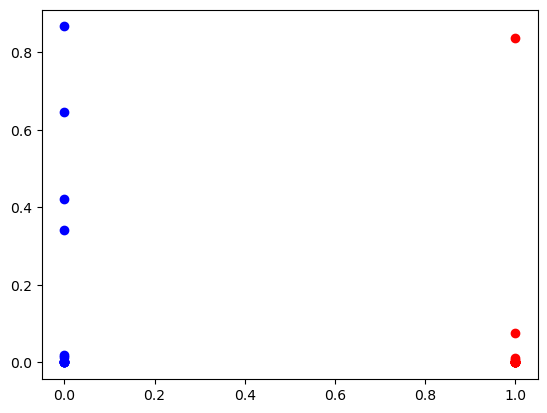

In [72]:
stat = "Fusobacterium_frac"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

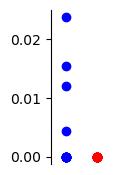

In [110]:
stat = "Rothia_Actinomyces_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots(figsize=(1,2))
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")
ax.set_xlim(-0.5, 2)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

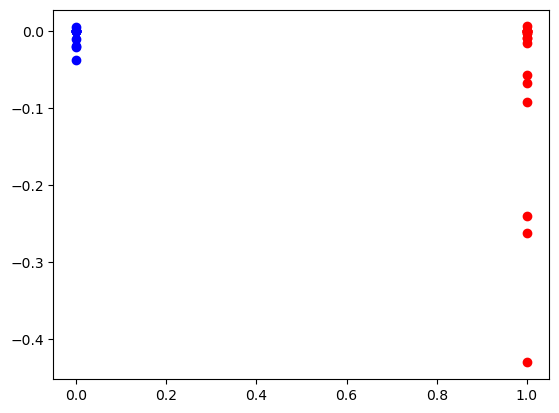

In [74]:
stat = "Gemella_Prevotella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

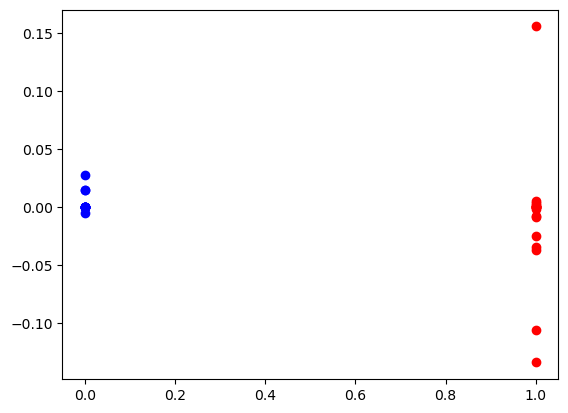

In [75]:
stat = "Lautropia_Gemella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

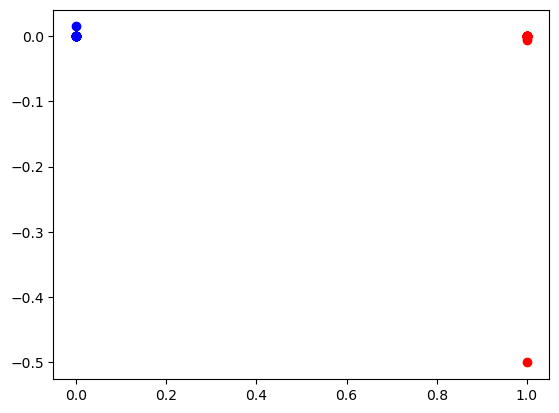

In [76]:
stat = "Actinomyces_Gemella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

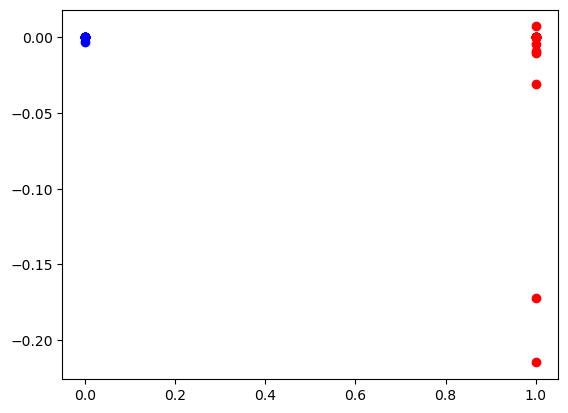

In [94]:
stat = "Porphyromonas_Pasteurellaceae_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

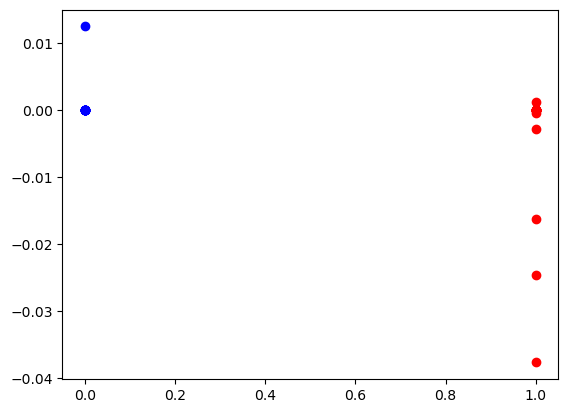

In [95]:
stat = "Porphyromonas_Prevotella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

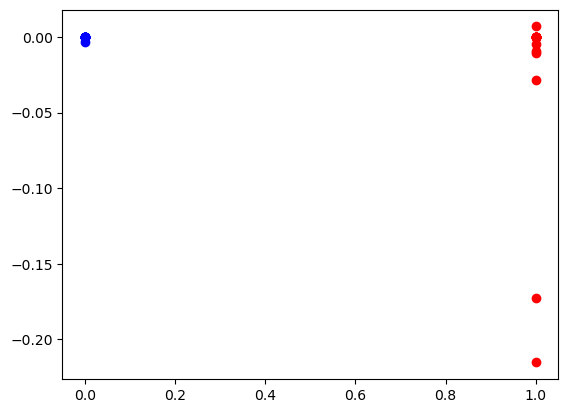

In [96]:
stat = "Pasteurellaceae_Porphyromonas_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

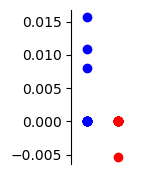

In [112]:
stat = "Leptotrichia_Pasteurellaceae_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots(figsize=(1,2))
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")
ax.set_xlim(-0.5, 2)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

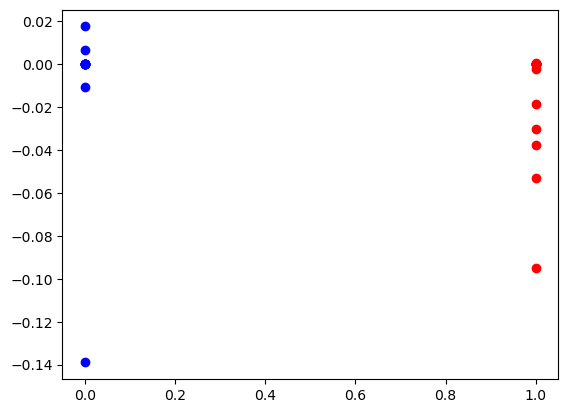

In [98]:
stat = "Pasteurellaceae_Selenomonas_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

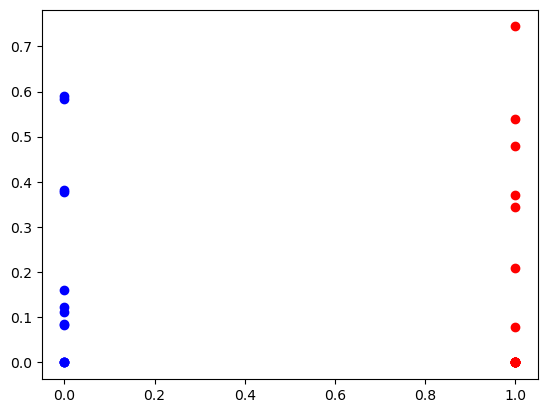

In [99]:
stat = "Fusobacterium_moran_i"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

disease vs healthy

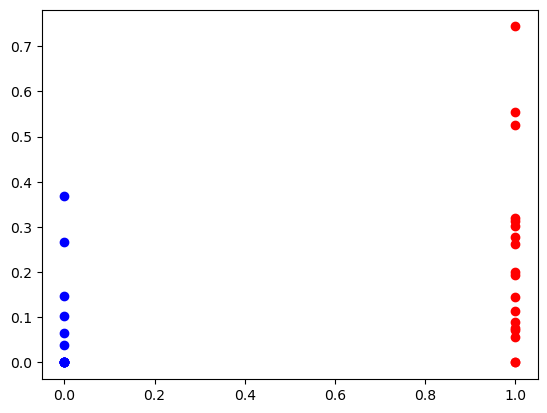

In [77]:
stat = "Gemella_moran_i"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

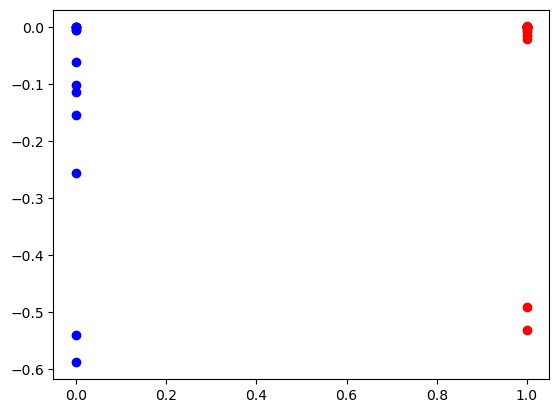

In [78]:
stat = "Fusobacterium_Pasteurellaceae_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

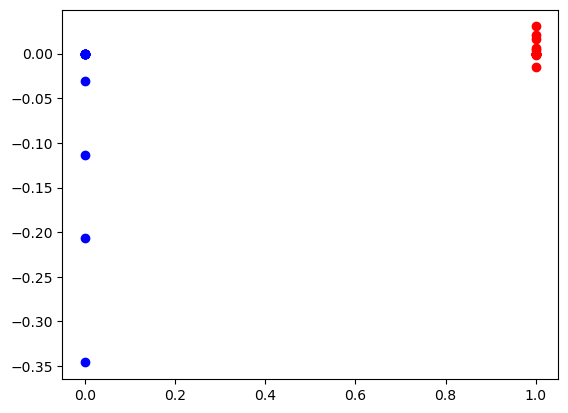

In [79]:
stat = "Selenomonas_Veillonella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

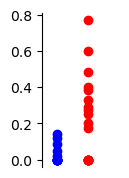

In [113]:
stat = "Lautropia_moran_i"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots(figsize=(1,2)
)
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")
ax.set_xlim(-0.5, 2)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)


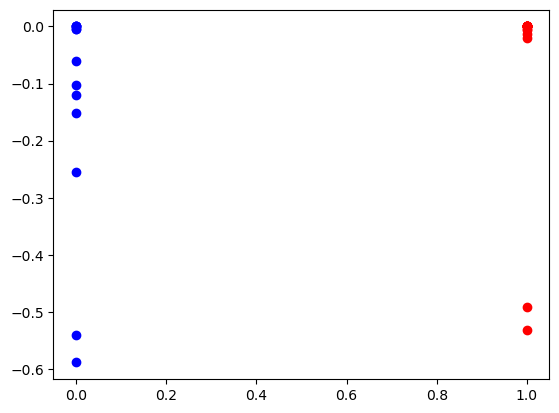

In [81]:
stat = "Pasteurellaceae_Fusobacterium_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

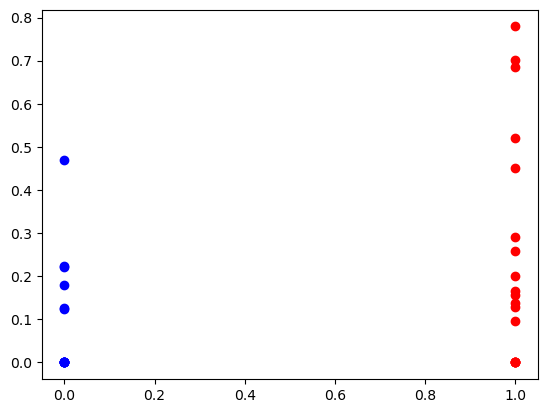

In [82]:
stat = "Prevotella_moran_i"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

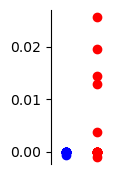

In [114]:
stat = "Selenomonas_Porphyromonas_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots(figsize=(1,2))
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

ax.set_xlim(-0.5, 2)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)


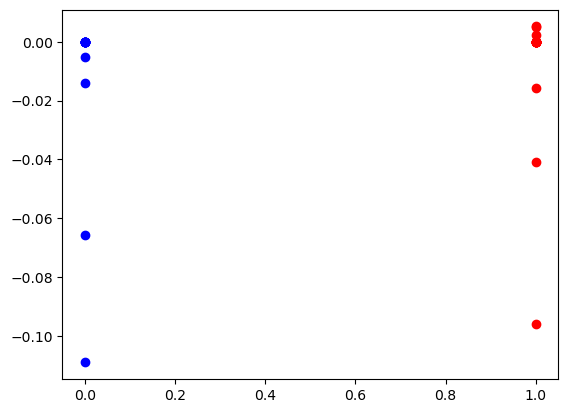

In [85]:
stat = "Selenomonas_Prevotella_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

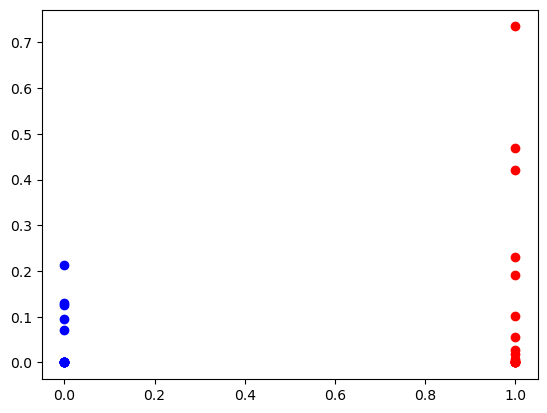

In [86]:
stat = "Prevotella_frac"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

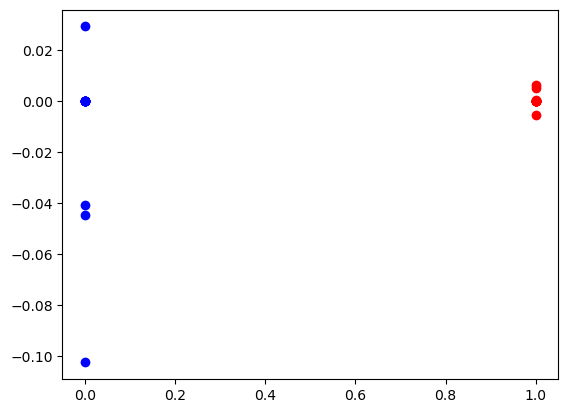

In [87]:
stat = "Actinomyces_Pasteurellaceae_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

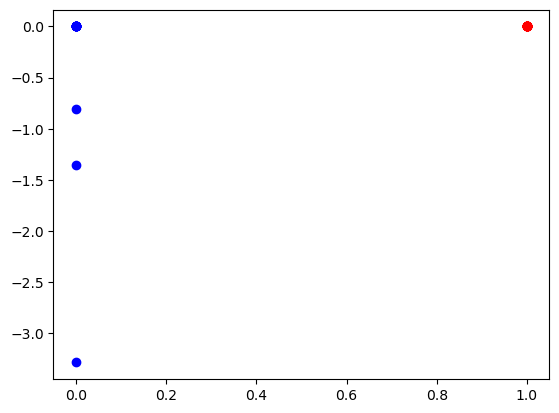

In [88]:
stat = "Leptotrichia_power_law"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

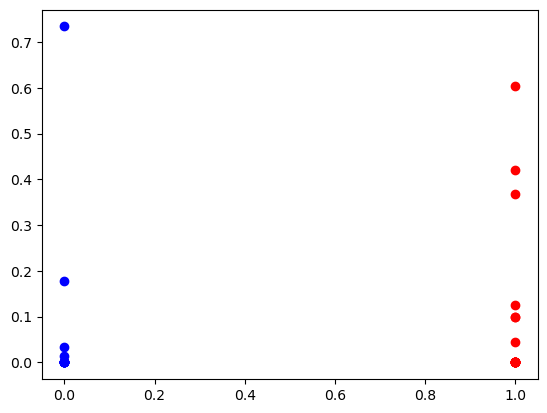

In [90]:
stat = "Streptococcus_moran_i"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")

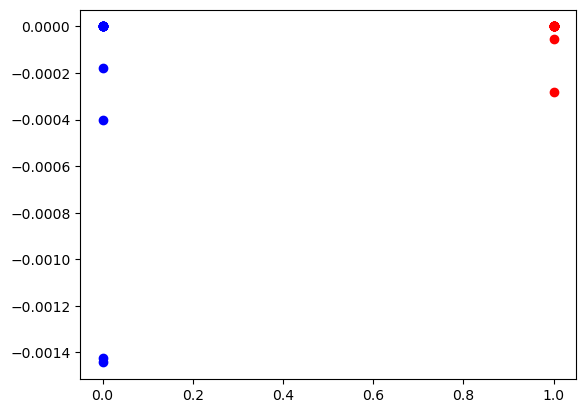

In [91]:
stat = "Actinomyces_Streptococcus_moran_bv"

bool_h = adata.obs.sample_type_implant == "healthy_implant"
bool_d = adata.obs.sample_type_implant == "disease_implant"
stat_h = adata[bool_h, stat].X
stat_d = adata[bool_d, stat].X
fig, ax = plt.subplots()
ax.scatter([0]*len(stat_h), stat_h, color="b")
ax.scatter([1] * len(stat_d), stat_d, color="r")